In [1]:
import cupy as cp
import pandas as pd
import numpy as np
import threading
import queue
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class RobustOnlineHuberRegressorGPU:
    def __init__(self, k=1.345, fit_intercept=True, reg_param=1e-4):
        # 初始化模型參數 (Huber 閾值k、是否要截距、正則化參數)
        self.k = k
        self.fit_intercept = fit_intercept
        self.reg_param = reg_param
        self.A_total = None
        self.b_total = None
        self.coef_ = None
        self.intercept_ = 0.0 if fit_intercept else None

    def _huber_loss(self, theta, X, y):
        """計算 Huber 損失 (小誤差平方、大誤差線性)"""
        residuals = y - X.dot(theta)
        loss = cp.where(cp.abs(residuals) <= self.k, 
                        0.5 * residuals**2,
                        self.k * cp.abs(residuals) - 0.5 * self.k**2)
        return cp.mean(loss)

    def _huber_grad(self, theta, X, y):
        """計算 Huber 損失的梯度，用來做梯度下降"""
        residuals = y - X @ theta
        abs_r = cp.abs(residuals)
        mask = cp.where(abs_r <= self.k, 
                        1.0, 
                        self.k / abs_r)
        grad = - X.T @ (mask * residuals)
        return grad / X.shape[0]

    def predict(self, X):
        """用已訓練好的係數預測 y"""
        if isinstance(self.coef_, cp.ndarray):
            coef = cp.asnumpy(self.coef_)
        else:
            coef = self.coef_

        if isinstance(self.intercept_, cp.ndarray):
            intercept = cp.asnumpy(self.intercept_)
        else:
            intercept = self.intercept_

        return X @ coef + intercept

    def fit_batch(self, X_batch, y_batch, stream=None):
        """在指定 stream 中執行 GPU 運算"""
        with stream if stream is not None else cp.cuda.Stream.null:
            if self.fit_intercept:
                X_batch = cp.column_stack([cp.ones(len(X_batch)), X_batch])
            
            if self.A_total is None:
                n_features = X_batch.shape[1]
                self.A_total = cp.eye(n_features) * self.reg_param
                self.b_total = cp.zeros(n_features)
            
            # 初始值用Least Squares Method
            theta_t = cp.linalg.lstsq(X_batch, y_batch, rcond=None)[0]

            # 手動梯度下降
            for _ in range(100):
                grad = self._huber_grad(theta_t, X_batch, y_batch)
                theta_t -= 0.01 * grad

            # 累積統計量
            A_t = X_batch.T @ X_batch
            self.A_total += A_t
            self.b_total += A_t @ theta_t

    def finalize(self):
        """根據所有批次的累積統計量，解出最終模型係數"""
        self.A_total += cp.eye(self.A_total.shape[0]) * self.reg_param
        self.coef_ = cp.linalg.solve(self.A_total, self.b_total)
        
        if self.fit_intercept:
            self.intercept_ = self.coef_[0]
            self.coef_ = self.coef_[1:]
        return self

In [3]:
class DataPipeline:
    def __init__(self, X_train, y_train, batch_size=10000, max_queue_size=3):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.data_queue = queue.Queue(maxsize=max_queue_size)
        self.finished = False
        self.total_batches = (len(X_train) + batch_size - 1) // batch_size
        
    def _data_preparation_thread(self):
        """背景執行緒：資料準備和預處理"""
        for i in range(0, len(self.X_train), self.batch_size):
            if self.finished:
                break
                
            # 步驟 1：切片資料 (CPU)
            X_batch = self.X_train[i:i+self.batch_size]
            y_batch = self.y_train.iloc[i:i+self.batch_size].values

            # 步驟 2：非同步轉換為 CuPy 陣列 (CPU→GPU)
            stream = cp.cuda.Stream(non_blocking=True)  # 建立非同步 Stream
            with stream:
                X_batch_gpu = cp.asarray(X_batch, order='C')  # Host → Device
                y_batch_gpu = cp.asarray(y_batch, order='C')

            # 步驟 3：放入佇列（包含 stream）
            batch_data = (X_batch_gpu, y_batch_gpu, i // self.batch_size + 1, stream)
            if self.data_queue.full():
               print(f"[警告] queue 已滿，背景 thread 等待中")

            self.data_queue.put(batch_data)

            if i // self.batch_size % 10 == 0:
                print(f"完成批次 {i//self.batch_size + 1}/{self.total_batches}")

        print("資料準備執行緒完成")
    
    def start_pipeline(self):
        """啟動資料pipeline"""
        # 啟動背景執行緒
        self.thread = threading.Thread(target=self._data_preparation_thread, daemon=True) # dermon 設定為背景執行序
        self.thread.start()
        
    def get_batch(self):
        """主執行緒呼叫：取得下一批資料"""
        try:
            return self.data_queue.get(timeout=30)  # 30秒超時
        except queue.Empty:
            return None
    
    def mark_batch_done(self):
        """標記批次處理完成"""
        self.data_queue.task_done()
    
    def stop_pipeline(self):
        """停止pipeline(發出結束信號並等待結束)"""
        self.finished = True
        if hasattr(self, 'thread'): # 判斷是否有thread屬性
            self.thread.join() # .join 等待thread結束再繼續

# 原始資料預處理 - 根據資料修改
def preprocess_data(df):
    """資料預處理 """
    categories = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
    for col in categories:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    return df

# 1. 載入資料

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


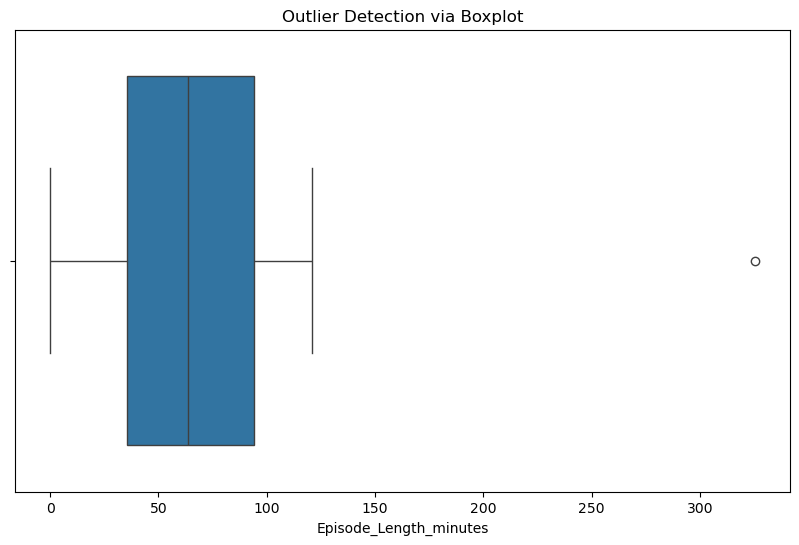

In [ ]:
df = pd.read_csv("dataset/playground-series-s5e4/train.csv")
df.info()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df["Episode_Length_minutes"])
plt.title("Outlier Detection via Boxplot")
plt.show()

# 2. 資料預處理

In [5]:
print(df[df["Episode_Length_minutes"] > 300])
df = df.drop(101637, axis=0)  # 異常值處理

# 缺失值填補
df["Episode_Length_minutes"] = df["Episode_Length_minutes"].fillna(df["Episode_Length_minutes"].mean())
df["Guest_Popularity_percentage"] = df["Guest_Popularity_percentage"].fillna(df["Guest_Popularity_percentage"].mean())

# 處理低頻類別
counts = df["Number_of_Ads"].value_counts()
remove = counts[(counts == 1) | (counts == 2)].index
df = df[~df["Number_of_Ads"].isin(remove)]
df["Number_of_Ads"] = df["Number_of_Ads"].fillna(df["Number_of_Ads"].median())

# 類別編碼
df = preprocess_data(df)

            id   Podcast_Name Episode_Title  Episode_Length_minutes  \
101637  101637  Home & Living    Episode 16                  325.24   

            Genre  Host_Popularity_percentage Publication_Day  \
101637  Lifestyle                       50.69         Tuesday   

       Publication_Time  Guest_Popularity_percentage  Number_of_Ads  \
101637        Afternoon                        15.01            0.0   

       Episode_Sentiment  Listening_Time_minutes  
101637          Positive                64.31981  


In [6]:
X = df.drop(columns=['Listening_Time_minutes', 'id', 'Episode_Title', "Podcast_Name"])
y = df['Listening_Time_minutes']

# 4. 分割資料
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 6. 資料驗證
X_train_scaled = cp.asarray(X_train_scaled)
assert not cp.any(cp.isnan(X_train_scaled)), "訓練集仍含NaN"
assert not cp.any(cp.isinf(X_train_scaled)), "訓練集含Inf"

# 3. 使用 Data Pipeline 訓練模型

In [7]:
print("Data Pipeline 訓練...")
batch_size = 50000

# 初始化模型
huber_model = RobustOnlineHuberRegressorGPU(
    k=1.345,
    fit_intercept=True, 
    reg_param=1e-4
)

# 初始化資料pipeline
pipeline = DataPipeline(X_train_scaled, y_train, batch_size)

# 啟動pipeline
start_time = time.time()
pipeline.start_pipeline()

# 主迴圈：GPU 運算與記憶體傳輸重疊
batch_count = 0
gpu_time = 0
prev_stream = None

while True:
    # 從佇列取得批次資料
    batch_data = pipeline.get_batch()
    if batch_data is None:
        break
        
    X_batch, y_batch, batch_id, stream = batch_data
    
    # 等待前一個批次的 GPU 運算完成（如果有的話）
    if prev_stream is not None:
        prev_stream.synchronize()
    
    # GPU 運算（使用當前批次的 stream，與下一批次的記憶體傳輸重疊）
    gpu_start = time.time()
    huber_model.fit_batch(X_batch, y_batch, stream)
    gpu_time += time.time() - gpu_start
    
    # 標記完成
    pipeline.mark_batch_done()
    batch_count += 1
    
    # 保存當前 stream 供下次迭代同步用
    prev_stream = stream

# 等待最後一個批次完成
if prev_stream is not None:
    prev_stream.synchronize()

# 停止pipeline
pipeline.stop_pipeline()

# 完成模型
huber_model.finalize()

total_time = time.time() - start_time

Data Pipeline 訓練...
完成批次 1/12
[警告] queue 已滿，背景 thread 等待中
[警告] queue 已滿，背景 thread 等待中
[警告] queue 已滿，背景 thread 等待中
[警告] queue 已滿，背景 thread 等待中
[警告] queue 已滿，背景 thread 等待中
[警告] queue 已滿，背景 thread 等待中
[警告] queue 已滿，背景 thread 等待中
完成批次 11/12
[警告] queue 已滿，背景 thread 等待中
資料準備執行緒完成


訓練完成統計：
總時間: 36.02秒
GPU 運算時間: 5.65秒
GPU 使用時間佔比: 15.7%
處理批次數: 12
模型效能：
MAE: 9.81
RMSE: 13.33


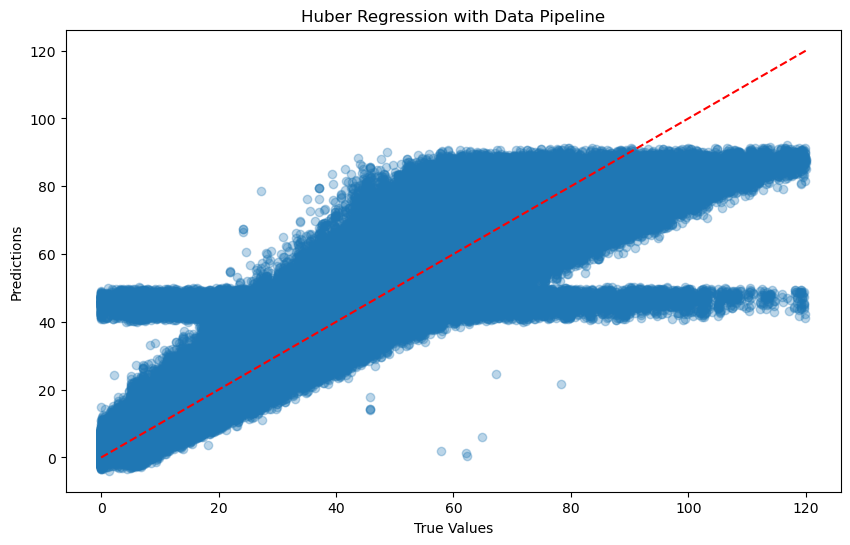

In [8]:
print(f"訓練完成統計：")
print(f"總時間: {total_time:.2f}秒")
print(f"GPU 運算時間: {gpu_time:.2f}秒")
print(f"GPU 使用時間佔比: {gpu_time/total_time*100:.1f}%")
print(f"處理批次數: {batch_count}")

# 8. 驗證模型
y_val_pred = huber_model.predict(X_val_scaled)

print(f"模型效能：")
print(f"MAE: {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"RMSE: {mean_squared_error(y_val, y_val_pred)**0.5:.2f}")

# 9. 視覺化結果
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Huber Regression with Data Pipeline")
plt.show()